In [1]:
import numpy as np

In [2]:
from pydrake.all import HPolyhedron

In [3]:
from terrain import terrain_to_trimesh, get_terrain_urdf
resolution = [20, 20]
height = np.random.rand(*resolution)*0.1
name = 'test_trimesh'
length = 1
width = 1

path_sdf, points, triangles = get_terrain_urdf(length, width, height, name)

In [4]:
radius = 0.01
ball_urdf = f'''
<robot name="ball_in_boxes">
  <link name="movable">
    <collision name="sphere">
      <geometry><sphere radius="{radius:.2f}"/></geometry>
    </collision>
    <visual name="sphere_vis">
      <geometry><sphere radius="{radius:.2f}"/></geometry>
    </visual>
  </link>
  <link name="for_joint"/>
  <link name="for_joint2"/>
  <joint name="x" type="prismatic">
    <axis xyz="1 0 0"/>
    <limit lower="-2" upper="2"/>
    <parent link="world"/>
    <child link="for_joint"/>
  </joint>
  <joint name="y" type="prismatic">
    <axis xyz="0 1 0"/>
    <limit lower="-2" upper="2"/>
    <parent link="for_joint"/>
    <child link="for_joint2"/>
  </joint>
  <joint name="z" type="prismatic">
    <axis xyz="0 0 1"/>
    <limit lower="-2" upper="2"/>
    <parent link="for_joint2"/>
    <child link="movable"/>
  </joint>
</robot>'''

In [5]:
from pydrake.all import(Meldis, 
                        RobotDiagramBuilder, 
                        MeshcatVisualizer, 
                        Rgba, 
                        Sphere, 
                        RigidTransform,
                        RotationMatrix)
from functools import partial
#meshcat = StartMeshcat()
meldis = Meldis()
meshcat = meldis.meshcat
builder = RobotDiagramBuilder()
plant = builder.plant()
scene_graph = builder.scene_graph()
parser = builder.parser()
model = parser.AddModels(path_sdf)
model2 = parser.AddModelsFromString(ball_urdf, "urdf")
frame = plant.GetFrameByName(f"{name}", model[0])
plant.WeldFrames(plant.world_frame(), frame)
plant.Finalize()
visualizer = MeshcatVisualizer.AddToBuilder(builder.builder(), scene_graph, meshcat)
diagram = builder.Build()
diagram_context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(diagram_context)
diagram.ForcedPublish(diagram_context)

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [7]:
import ipywidgets as widgets
q = np.zeros(plant.num_positions()) 
sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]*0.99
    q_high = plant.GetPositionUpperLimits()[i]*0.99
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, step=0.0001, description=f"q{i}"))
col_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_free =  Rgba(0.0, 0.8, 0.5, 0.5) 
def showres(qvis):
    plant.SetPositions(plant_context, qvis)
    diagram.ForcedPublish(diagram_context)
    query = plant.get_geometry_query_input_port().Eval(plant_context)
    col = query.HasCollisions()
    if col:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.2),
                                   col_col)
    else:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.2),
                                   col_free)
    meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  np.array([0,0,0.5])))
    return col

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=1.98, min=-1.98, step=0.0001)

FloatSlider(value=0.0, description='q1', max=1.98, min=-1.98, step=0.0001)

FloatSlider(value=0.0, description='q2', max=1.98, min=-1.98, step=0.0001)

In [7]:
resolution = [3, 4]
height = np.random.rand(*resolution)

xlen = 5
ylen = 5

vertex_locations = np.zeros(tuple(resolution+[3]))
for x in range(resolution[0]):
    for y in range(resolution[1]):
        vertex_locations[x,y, 0] = xlen/resolution[0]*x -xlen/2
        vertex_locations[x,y, 1] = ylen/resolution[1]*y -ylen/2
        vertex_locations[x,y, 2] = height[x,y]

vertices = vertex_locations.reshape(-1,3)
min_z = np.min(vertex_locations[:,-1]) -0.1
vertex_ends = np.array([vertex_locations[0,0, :], 
               vertex_locations[-1,0, :],
               vertex_locations[-1,-1, :],
               vertex_locations[0,-1, :]])

vertex_ends[:,-1] = min_z

idx_0_0 = len(vertices)
idx_l_0 = len(vertices)+1
idx_l_l = len(vertices)+2
idx_0_l = len(vertices)+3
vertices = np.concatenate((vertices, vertex_ends), axis = 0)

triangles = []
for idx_x in range(resolution[0]-1):
    for idx_y in range(resolution[1]-1):
        curr_vertex = idx_x*resolution[1] + idx_y
        vertex_top = (idx_x + 1)*resolution[1] + idx_y
        vertex_right = idx_x*resolution[1] + idx_y+1
        vertex_right_top = (idx_x + 1)*resolution[1] + (idx_y+1)
        triangles.append([curr_vertex, vertex_right, vertex_right_top])
        triangles.append([curr_vertex, vertex_right_top, vertex_top])

triangles.append([idx_0_0, idx_l_0, idx_l_l])
triangles.append([idx_0_0, idx_l_l, idx_0_l])

In [11]:
triangles[-2:]


[[12, 13, 14], [12, 14, 15]]

In [12]:
triangles

[[0, 1, 5],
 [0, 5, 4],
 [1, 2, 6],
 [1, 6, 5],
 [2, 3, 7],
 [2, 7, 6],
 [4, 5, 9],
 [4, 9, 8],
 [5, 6, 10],
 [5, 10, 9],
 [6, 7, 11],
 [6, 11, 10],
 [12, 13, 14],
 [12, 14, 15]]

In [8]:
def save_obj(file_path, vertices, triangles):
    with open(file_path, 'w') as obj_file:
        # Write vertices
        for vertex in vertices:
            formatted_vertex = ' '.join(format(coord, '.4f') for coord in vertex)
            obj_file.write(f"v {formatted_vertex}\n")

        # Write triangles
        for triangle in triangles[:-1]:
            obj_file.write(f"f {' '.join(map(str, triangle))}\n")
        obj_file.write(f"f {' '.join(map(str, triangles[-1]))}")

In [9]:
save_obj('test.obj', vertices, triangles)

In [19]:
triangles

[[0, 1, 5],
 [0, 5, 4],
 [1, 2, 6],
 [1, 6, 5],
 [2, 3, 7],
 [2, 7, 6],
 [4, 5, 9],
 [4, 9, 8],
 [5, 6, 10],
 [5, 10, 9],
 [6, 7, 11],
 [6, 11, 10],
 [12, 13, 14],
 [12, 14, 15]]

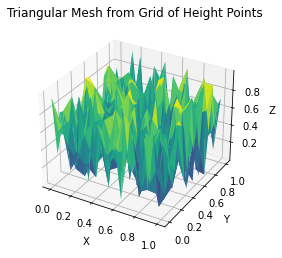

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

def generate_trimesh(grid_size):
    # Generate a grid of height points
    x, y = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
    z = np.random.rand(grid_size, grid_size)  # You can replace this with your own height data
    
    # Flatten the arrays for Delaunay triangulation
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))
    
    # Perform Delaunay triangulation
    tri = Delaunay(points[:, :2])

    # Create the trimesh
    trimesh = {'vertices': points, 'faces': tri.simplices}

    return trimesh

def plot_trimesh(trimesh):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trimesh
    ax.plot_trisurf(trimesh['vertices'][:, 0], trimesh['vertices'][:, 1], trimesh['vertices'][:, 2],
                    triangles=trimesh['faces'], cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Triangular Mesh from Grid of Height Points')

    plt.show()

grid_size = 20  # Adjust the grid size as needed
trimesh = generate_trimesh(grid_size)
plot_trimesh(trimesh)

In [22]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

length = 1
width = 2
resx = 10
resy = 10
output_file = 'terrain2.obj'

# def terrain_to_trimesh(length, 
#                        width, 
#                        resx,
#                        resy, 
#                        output_file):
resolution = [resx, resy]
# Generate a grid of height points
x, y = np.meshgrid(np.linspace(0, length, resolution[0])-length/2, np.linspace(0, width, resolution[1])-width/2)
z = np.random.rand(resolution[0], resolution[1])  # You can replace this with your own height data

# Flatten the arrays for Delaunay triangulation
points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

# Perform Delaunay triangulation
tri = Delaunay(points[:, :2])

#print(tri.simplices)
minz = np.min(points[:,-1]) - 4.0
# vertices_box = [
#     (-length / 2, -width / 2, minz),
#     (length / 2, -width / 2, minz),
#     (length / 2, width / 2, minz),
#     (-length / 2, width / 2, minz),
#     (-length / 2, -width / 2, z[0,0]),
#     (length / 2, -width / 2, z[0,-1]),
#     (length / 2, width / 2, z[-1,-1]),
#     (-length / 2, width / 2, z[-1,0])
# ]
terrain_verts = points#np.concatenate((points, np.array(vertices_box)), axis = 0)
len_surf_verts = len(points)


# Define triangles (faces) using three vertices each
faces_box = [
    [1, 2, 3],
    [1, 3, 4],
    # [5, 8, 7],
    # [5, 7, 6],
    [1, 5, 6],
    [1, 6, 2],
    [2, 6, 7],
    [2, 7, 3],
    [3, 7, 8],
    [3, 8, 4],
    (5, 1, 4),
    (5, 4, 8)
]
faces_tot = []
for f in tri.simplices:
    faces_tot.append([a+1 for a in f])
# for face in faces_box:
#     faces_tot.append([f+len_surf_verts for f in face])

with open(output_file, 'w') as obj_file:
    obj_file.write("# terrain\n")

    # Write vertices
    for vertex in terrain_verts:
        obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

    # Write faces
    for face in faces_tot: 
        obj_file.write(f"f {' '.join(map(str, face))}\n")



# terrain_to_trimesh(length, width, resx, resy, 'terrain.obj')

In [18]:
len(tri.simplices)

162

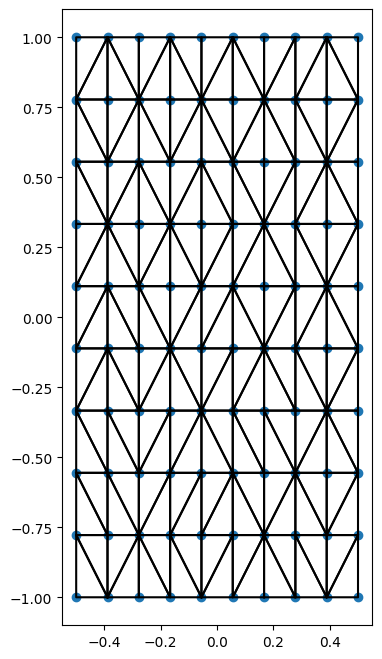

In [21]:
import matplotlib.pyplot as plt
def plot_tri(ax, tri, pts_flat):
    linepts = np.concatenate((pts_flat[np.array(tri)-1,:], pts_flat[tri[0]-1,:].reshape(1,-1)),axis = 0)
    plt.plot(linepts[:,0], linepts[:,1], c = 'k')


fig = plt.figure(figsize=(4,8))
ax = plt.gca()
ax.scatter(points[:,0], points[:,1])
for t in faces_tot:
    plot_tri(ax, t, points)



In [36]:
idx_x = 3
idx_y = 24

curr_vertex = idx_x*resolution[1] + idx_y

print(vertex_locations[idx_x, idx_y])
print(vertices[curr_vertex])

[-26.4        -10.4          0.62076542]
[-26.4        -10.4          0.62076542]


In [24]:
vertex_locations[0,:]

array([[-30.        , -20.        ,   0.05476442],
       [-30.        , -16.        ,   0.82901909],
       [-30.        , -12.        ,   0.06528609],
       [-30.        ,  -8.        ,   0.08220584],
       [-30.        ,  -4.        ,   0.06059738],
       [-30.        ,   0.        ,   0.43300009],
       [-30.        ,   4.        ,   0.07892403],
       [-30.        ,   8.        ,   0.39585374],
       [-30.        ,  12.        ,   0.93001028],
       [-30.        ,  16.        ,   0.23018456]])

In [29]:
vertices[0:resolution[1], :]

array([[-30.        , -20.        ,   0.05476442],
       [-30.        , -16.        ,   0.82901909],
       [-30.        , -12.        ,   0.06528609],
       [-30.        ,  -8.        ,   0.08220584],
       [-30.        ,  -4.        ,   0.06059738],
       [-30.        ,   0.        ,   0.43300009],
       [-30.        ,   4.        ,   0.07892403],
       [-30.        ,   8.        ,   0.39585374],
       [-30.        ,  12.        ,   0.93001028],
       [-30.        ,  16.        ,   0.23018456]])

In [27]:
resolution[0]

5